# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [41]:
%matplotlib inline
#import warnings
#warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE  Score!=3  LIMIT 3000""", con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(3000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [2]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [3]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(2991, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.7

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [4]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [5]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()
labels = final.head(998)
print(labels["ProfileName"])

(2991, 10)
2546                                        Alex Chaffee
2547                                            reader48
1145                                           B G Chase
1146                                              Robbie
2942                        T. Moore "thoughtful reader"
2941                         Glenna E. Bauer "Puppy Mum"
1071                                        Eric Hochman
2187                                       Internet Diva
2068                    Dr. Glenn B. Gero "NJnaturaldoc"
2069                                 The Barb Knows Best
2805                                      Shala Kerrigan
2806                        S. Jettlund "mamaknows2much"
1329                        John M. Bloom "dmetrixavier"
1332                         saphenomenon "saphenomenon"
1331                                         C. Dembosky
1330                                         S. Woodcock
1328    Judy J. Blaskowski "Coauthor of The Step Dyna...
2479                

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [7]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'does', 'through', 'by', "doesn't", 'a', 'there', "she's", 'doesn', 'll', 'isn', 'what', 'an', 'he', 'all', 'nor', 'so', 'than', 'can', 'was', 'were', 'am', 'the', 'over', "won't", "shouldn't", 'which', 'this', 'if', "mustn't", 'had', 'wasn', 'between', "wasn't", "didn't", 'why', 'hadn', 'ours', 'weren', 'our', 'ourselves', 'it', "needn't", 'having', 'won', 'their', 'such', "don't", 'm', 'you', "that'll", 'against', 'of', 'd', 'for', 'will', 'other', 'until', 'i', 'down', "should've", 'do', 're', 'yours', 'below', 'and', 'be', "you'd", 'about', 'theirs', 'but', 'under', 'whom', 'herself', 'how', 'above', 'we', 'myself', 'his', 'that', 'those', 'have', "hasn't", 'doing', 'from', 'in', 'shan', 'during', 'them', 'again', 'ma', "you'll", "shan't", 'more', 'further', 'because', "isn't", 'shouldn', 'few', 'own', 'as', 'o', 'or', 'are', 'into', 'her', 'mightn', 'didn', 'once', 'any', 'couldn', 'each', 'who', 'wouldn', 'out', 'off', "hadn't", 'before', 'my', 'hers', 'same', 'just', 'should', 

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [9]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.shape

(2991, 11)

In [42]:
print(final.head(3)) #below the processed review can be seen in the CleanedText Column 
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.shape

        Id   ProductId          UserId   ProfileName  HelpfulnessNumerator  \
2546  2774  B00002NCJC  A196AJHU9EASJN  Alex Chaffee                     0   
2547  2775  B00002NCJC  A13RRPGE79XFFH      reader48                     0   
1145  1244  B00002Z754  A3B8RCEI0FXFI6     B G Chase                    10   

      HelpfulnessDenominator     Score        Time  \
2546                       0  positive  1282953600   
2547                       0  positive  1281052800   
1145                      10  positive   962236800   

                             Summary  \
2546                   thirty bucks?   
2547                    Flies Begone   
1145  WOW Make your own 'slickers' !   

                                                   Text  \
2546  Why is this $[...] when the same product is av...   
2547  We have used the Victor fly bait for 3 seasons...   
1145  I just received my shipment and could hardly w...   

                                            CleanedText  
2546  product 

(2991, 11)

# [7.2.2] Bag of Words (BoW)

In [11]:
#BoW
#final_counts contains the Bag of Words for the unigram
#data is the processed data store in the new database created with name as final.
con1 = sqlite3.connect('final.sqlite') 
data = pd.read_sql_query("select* from Reviews",con1)
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(data['CleanedText'].values)

label = data["Score"]
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
#print(final_counts)
final_counts.shape

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2991, 6764)
the number of unique words  6764


(2991, 6764)

# Convert the sparse matrix into the dence matrix using TruncatedSVD
-> It reduces the dimensions of the data to 2. As n_components = 2 in the blow code.

In [15]:
# as we are going to use tsne and we know that tsne works only with dence matrix
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=2)
f = tsvd.fit_transform(final_counts) # conversion into dence matrix
f.shape

(2991, 2)

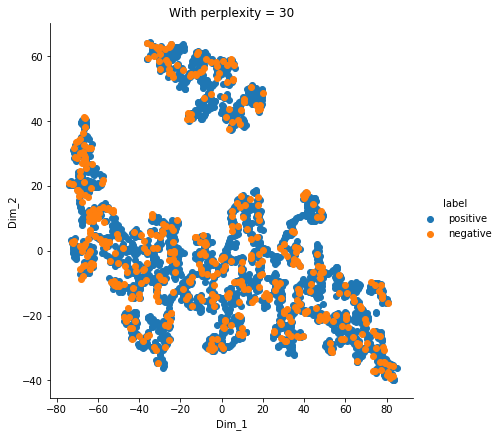

In [17]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data = model.fit_transform(f) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6)\
    .map(plt.scatter, 'Dim_1', 'Dim_2')\
    .add_legend()
plt.title('With perplexity = 30') # tsne plot using perplexity as 50
plt.show()

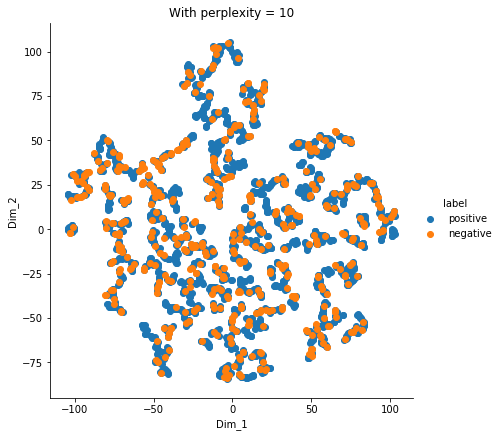

In [18]:
model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(f) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6)\
    .map(plt.scatter, 'Dim_1', 'Dim_2')\
    .add_legend()
plt.title('With perplexity = 10') # tsne plot using perplexity as 30
plt.show()

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [19]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 1121), (b'flavor', 1073), (b'tast', 960), (b'good', 954), (b'chip', 940), (b'great', 897), (b'love', 893), (b'one', 722), (b'use', 692), (b'tri', 679), (b'product', 640), (b'tea', 581), (b'bag', 566), (b'make', 543), (b'food', 524), (b'get', 484), (b'realli', 436), (b'eat', 426), (b'time', 417), (b'coffe', 408)]
Most Common Negative Words :  [(b'like', 268), (b'tast', 256), (b'product', 240), (b'flavor', 204), (b'chip', 170), (b'one', 167), (b'tri', 167), (b'would', 149), (b'bag', 144), (b'use', 136), (b'tea', 136), (b'order', 135), (b'good', 132), (b'food', 131), (b'buy', 109), (b'water', 105), (b'get', 102), (b'eat', 97), (b'even', 96), (b'amazon', 94)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

# for Bigram

In [12]:
#bi-gram, tri-gram and n-gram
#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(data['CleanedText'].values)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
#freq_dist_positive=nltk.FreqDist(all_positive_words)
#freq_dist_negative=nltk.FreqDist(all_negative_words)
#print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
#print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2991, 80594)
the number of unique words including both unigrams and bigrams  80594


In [21]:
#final_bigram_counts contain the vector representation of each review in high dimensions and it is a sparse matrix
print(type(final_bigram_counts))
print(final_bigram_counts.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(2991, 80594)


In [22]:
tsvd = TruncatedSVD(n_components=2)
f = tsvd.fit_transform(final_bigram_counts)#sparse matrix to dence matrix
f.shape

(2991, 2)

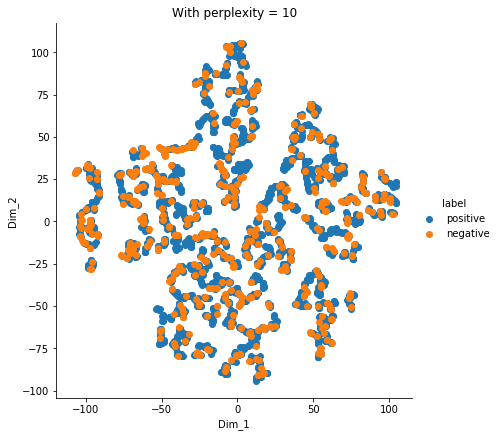

In [23]:
model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(f) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()



# trigram

In [13]:
count_vect = CountVectorizer(ngram_range=(1,3))
final_count = count_vect.fit_transform(data["CleanedText"].values)
final_count.shape

(2991, 178878)

In [16]:
tsvd = TruncatedSVD(n_components=2)
f = tsvd.fit_transform(final_count)
f.shape

(2991, 2)

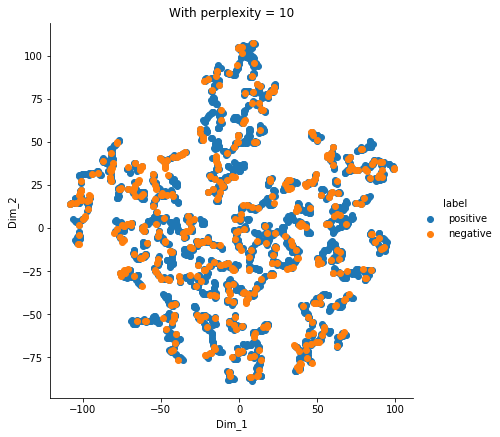

In [28]:
model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(f) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

# [7.2.5] TF-IDF

In [17]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print(final_tf_idf.shape)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

(2991, 80594)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2991, 80594)
the number of unique words including both unigrams and bigrams  80594


In [18]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10000:10010])
print(len(features))


some sample features(unique words in the corpus) ['call manufactur', 'call meltaway', 'call much', 'call muncho', 'call name', 'call one', 'call packet', 'call pepper', 'call pineappl', 'call pocki']
80594


In [19]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)
print(top_tfidf.shape)

(25, 2)


In [33]:
top_tfidf
print(type(final_tf_idf))
final_tf_idf.shape

<class 'scipy.sparse.csr.csr_matrix'>


(2991, 80594)

(2991, 2)


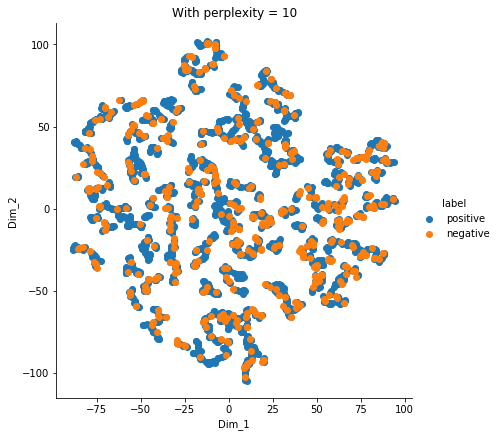

In [34]:
tsvd = TruncatedSVD(n_components=2)
tsne_data = tsvd.fit_transform(final_tf_idf)
print(tsne_data.shape)

model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(tsne_data) 

# creating a new data fram which help us in ploting the result data


tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

# [7.2.6] Word2Vec

In [22]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# There is a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# i could not apply google pre trained model as my systems memory was less.

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print("the vector representation of word 'computer'",model.wv['computer'])
print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

MemoryError: 

In [20]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [21]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

product avail www amazon com victor trap unreal cours total fli genocid pretti stinki right nearbi
*****************************************************************
['product', 'avail', 'www', 'amazon', 'com', 'victor', 'trap', 'unreal', 'cours', 'total', 'fli', 'genocid', 'pretti', 'stinki', 'right', 'nearbi']


In [22]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [23]:
print(type(w2v_model))
w2v_words = list(w2v_model.wv.vocab)
print(type(w2v_words))
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
print(type(w2v_words))

<class 'gensim.models.word2vec.Word2Vec'>
<class 'list'>
number of words that occured minimum 5 times  2267
sample words  ['product', 'avail', 'www', 'amazon', 'com', 'cours', 'total', 'fli', 'pretti', 'stinki', 'right', 'nearbi', 'use', 'season', 'cant', 'beat', 'great', 'receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'love', 'call', 'instead', 'sticker', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'car', 'beauti', 'shop', 'program', 'go', 'lot', 'fun', 'everywher', 'like', 'monitor', 'realli', 'good', 'idea', 'final', 'outstand', 'everybodi', 'ask']
<class 'list'>


In [24]:
print(w2v_model.wv.most_similar('tasti'))
print(type(w2v_model))
print(w2v_words[1])

[('textur', 0.9996945858001709), ('crisp', 0.9995626211166382), ('plain', 0.9995456337928772), ('nice', 0.9995236396789551), ('light', 0.9994606971740723), ('perfect', 0.9994568824768066), ('amount', 0.9994415044784546), ('without', 0.9994275569915771), ('good', 0.9994176626205444), ('fri', 0.9994174838066101)]
<class 'gensim.models.word2vec.Word2Vec'>
avail


In [25]:
print(w2v_model.wv.most_similar('good'))
print("********************************")
print(w2v_model.wv.most_similar('tasti'))

[('popchip', 0.9994667768478394), ('satisfi', 0.9994350671768188), ('tasti', 0.999417781829834), ('textur', 0.9994027018547058), ('great', 0.999373733997345), ('thai', 0.9993654489517212), ('there', 0.999351441860199), ('option', 0.9993492960929871), ('expect', 0.9993461966514587), ('intak', 0.999323844909668)]
********************************
[('textur', 0.9996945858001709), ('crisp', 0.9995626211166382), ('plain', 0.9995456337928772), ('nice', 0.9995236396789551), ('light', 0.9994606971740723), ('perfect', 0.9994568824768066), ('amount', 0.9994415044784546), ('without', 0.9994275569915771), ('good', 0.9994176626205444), ('fri', 0.9994174838066101)]


In [40]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(type(count_vect))
print(count_vect_feat[count_vect_feat.index('like')])

<class 'sklearn.feature_extraction.text.CountVectorizer'>
like


In [27]:
type(w2v_model)

gensim.models.word2vec.Word2Vec

# [7.2.7] Avg W2V, TFIDF-W2V

In [28]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2991
50


In [29]:

x = np.array(sent_vectors)
x.shape
print(x.shape)
print(type(x))

(2991, 50)
<class 'numpy.ndarray'>


In [30]:
col_mean = np.nanmean(x, axis=0)
print(len(col_mean))

50


In [31]:
inds = np.where(np.isnan(x))
print(inds)

(array([], dtype=int64), array([], dtype=int64))


In [32]:
x[inds] = np.take(col_mean, inds[1])

In [33]:
from sklearn import preprocessing
avg_vec_norm = preprocessing.normalize(x)

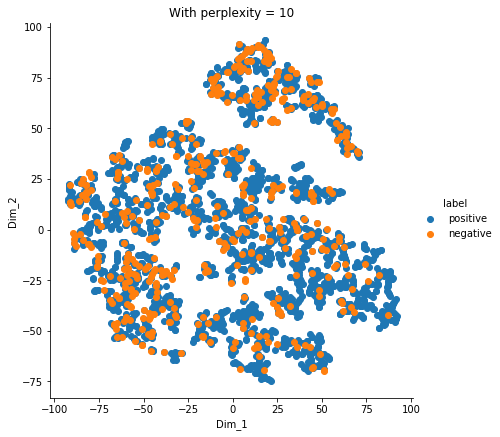

In [35]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(sent_vectors) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6)\
    .map(plt.scatter, 'Dim_1', 'Dim_2')\
    .add_legend()
plt.title('With perplexity = 10')
plt.show()

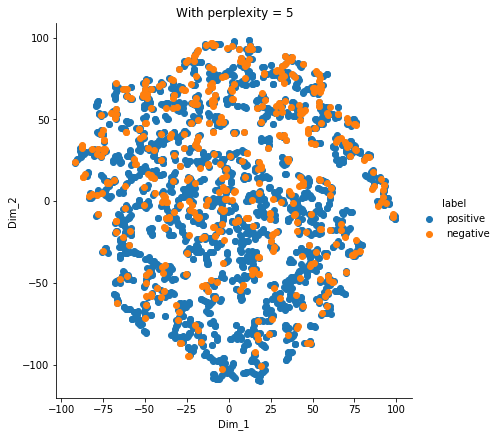

In [36]:
#tsne = TSNE(n_components = 2)
#d = tsne.fit_transform()
model = TSNE(n_components=2, random_state=0, perplexity=5)
tsne_data = model.fit_transform(sent_vectors) 
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 5')
plt.show()

# tfidf weighted Word2Vec

In [37]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

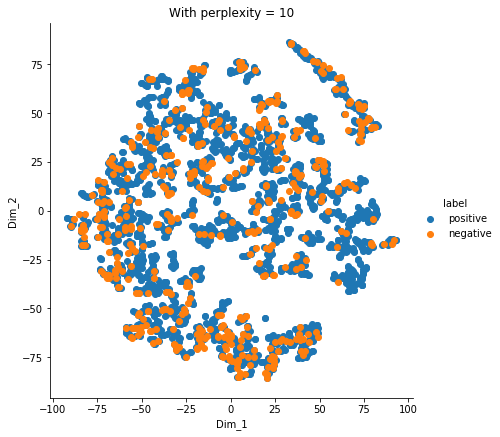

In [38]:
model = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data = model.fit_transform(tfidf_sent_vectors) 
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 10')
plt.show()

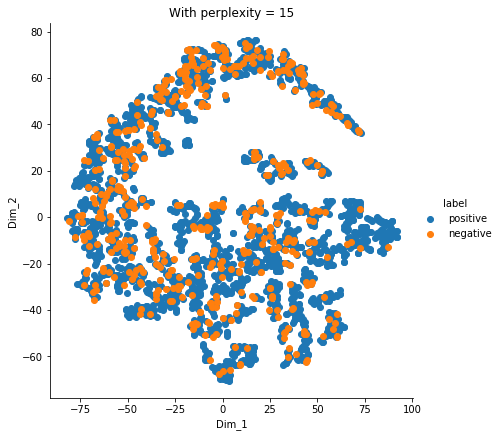

In [39]:
model = TSNE(n_components=2, random_state=0, perplexity=15)
tsne_data = model.fit_transform(tfidf_sent_vectors) 
# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, label)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 15')
plt.show()

# Observations:
1. By seeing the above plots we can say that our data can not be classified in positive and negative without any classification technique as most of the points are jumbled with each other.
